<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_08_Database_Managment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Database Management at "The Office"
Welcome to the chapter on Database Management. This topic is an integral part of database systems and has a direct impact on the efficiency, security, reliability, and overall performance of these systems. The importance of database management can't be overstated, as it plays a pivotal role in the smooth operation of businesses and organizations, allowing them to process transactions, secure sensitive information, ensure data consistency, and make informed decisions.

Database management isn't just about storing data; it's about storing it in a way that makes it easily retrievable, secure, and consistent. It includes the techniques and tools that enable the performance optimization of a database, manage the data and transactions, maintain the security and privacy of the data, and also facilitate data recovery in case of any failure or mishap.

In this chapter, we will delve into the specifics of database management. We will discuss key topics like transactions, performance optimization, security, the role of database systems in business, and more. To make these topics more approachable and easier to understand, we will relate them to real-world scenarios throughout the chapter.

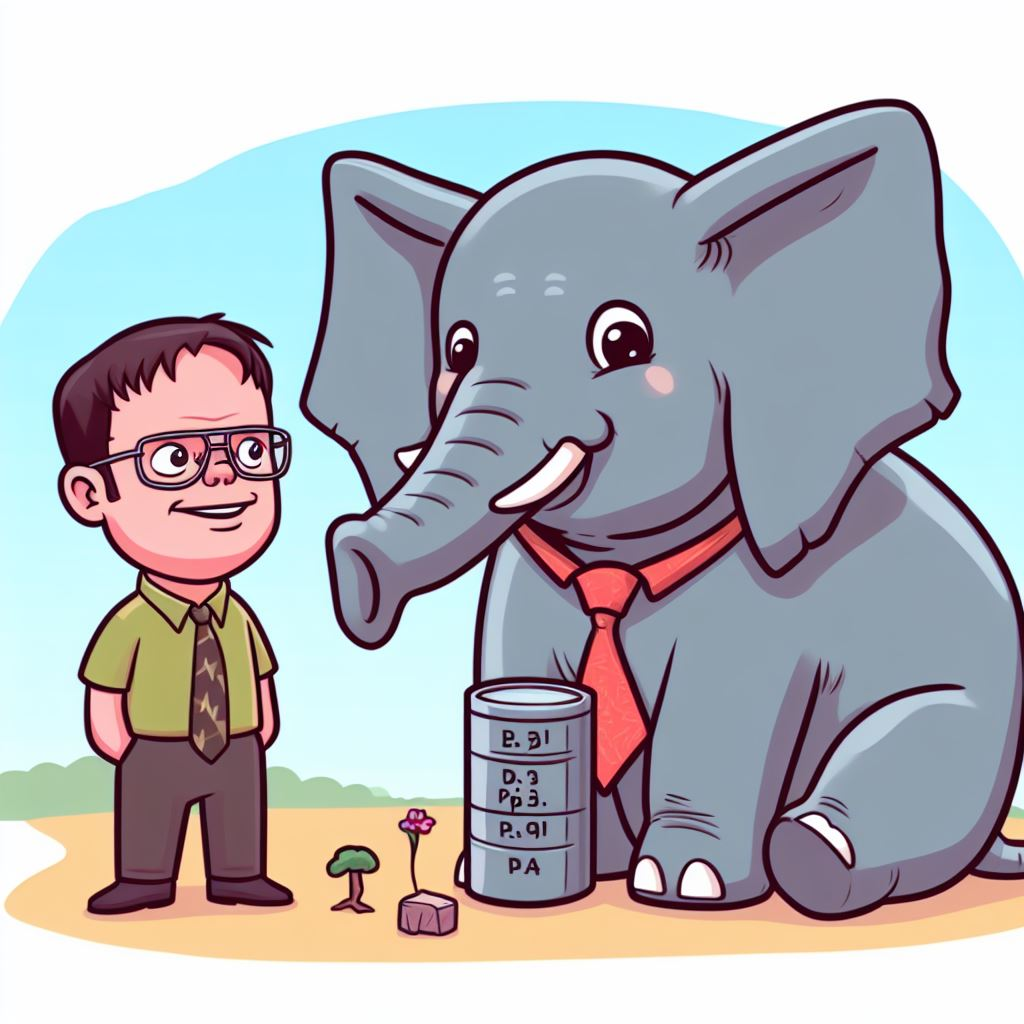

## Brendan's Lecture


In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo('a_OSyNF3gDQ', width=800, height=500)

## Case Study Introduction

Let's imagine Dunder Mifflin, a mid-sized paper supply company known to many from the TV show The Office. In the heart of Scranton, Pennsylvania, Dunder Mifflin maintains a busy workflow, with various departments such as sales, accounting, customer service, and human resources, all relying on data to carry out their operations.

They have a database filled with various types of data, including employee information, client details, product inventory, sales orders, and more. Given the volume and variety of data, the database system's role becomes crucial to support the day-to-day operations, strategic planning, and the overall success of Dunder Mifflin.

Through this case study, we'll explore how different aspects of database management apply to Dunder Mifflin's operations. We'll discuss how transactions are processed, the role of performance optimization techniques like indexing, how security measures like database views protect sensitive data, and how the database system contributes to the company's broader business goals.

As we journey through the complex yet intriguing landscape of database management, we'll get a deeper understanding of its importance, not just theoretically, but in a practical, business-oriented setting.

Here are the databases we'll be working with:

In [ ]:
# For this chapter, we need to use PostgreSQL,
# which has more advanced indexing and database management abilities

!apt install postgresql postgresql-contrib &>log
!service postgresql start
!sudo -u postgres psql -c "CREATE USER root WITH SUPERUSER"
# set connection
%load_ext sql
%sql postgresql+psycopg2://@/postgres

 * Starting PostgreSQL 14 database server
   ...done.
CREATE ROLE


## Introduction to the Dundler Mifflin Database
In any organization, data is often one of the most valuable assets. It gives the company insights into its operations and helps make informed decisions. For Dunder Mifflin, a fictional paper sales company, data is stored in a relational database, organized into tables that represent different entities in the organization. Let's take a closer look at the design of this database and understand why it's structured the way it is. (You can see the SQL code immediately following this section).

![Dunder Mifflin Database](https://github.com/brendanpshea/database_sql/raw/main/images/dunder_mifflin.png)





### Employees Table

The Employees table represents the employees of Dunder Mifflin. Each employee is uniquely identified by an 'employee_id'. This is the table's primary key, ensuring there are no duplicates and every employee can be uniquely identified. Other fields include the employee's first name, last name, email, and job title. Note that the email field is also unique, reflecting the real-world constraint that each employee should have a distinct email address.

### Clients Table

The Clients table represents the clients Dunder Mifflin does business with. Much like the Employees table, each client is uniquely identified by a 'client_id'. The company name is mandatory ('NOT NULL'), reflecting the business rule that every client must be associated with a company. Contact details and the company's location details are also stored here.

### Products Table

The Products table keeps track of the products Dunder Mifflin sells. Each product has a unique 'product_id' and must have a name and a price. The price must also be non-negative, which is enforced by a 'CHECK' constraint. This illustrates how databases can enforce data integrity at the field level.

### Orders Table

The Orders table represents the business transactions, i.e., the orders made by clients. Each order has a unique 'order_id' and is associated with a client and an employee, who are referenced by their respective IDs. This creates a relationship between the tables: for each record in the Orders table, there is a corresponding client in the Clients table and an employee in the Employees table. This association is enforced through 'FOREIGN KEY' constraints, which maintain the integrity of these relationships.

### OrderDetails Table

The OrderDetails table describes the specific items included in each order, connecting the order to the Products table. Each order detail record is uniquely identified by a combination of 'order_id' and 'product_id', meaning that the same product can appear only once in each order (though it can appear in multiple different orders). This is an example of a composite primary key.

This database design reflects a common approach in relational databases: breaking down information into smaller, manageable pieces and defining relationships between them. Entities are represented as tables (Employees, Clients, Products), and relationships are enforced through foreign keys (in Orders and OrderDetails). The choice of data types and constraints reflects the nature of the data and ensures its integrity. For example, email addresses are unique and non-nullable, prices are non-negative, etc.

In [ ]:
%%sql
-- The Employees table represents the employees of Dunder Mifflin.
DROP TABLE IF EXISTS employees cascade;
CREATE TABLE employees (
    employee_id INT PRIMARY KEY,  -- Every employee has a unique ID
    first_name VARCHAR(255) NOT NULL,  -- Employees' first names cannot be null
    last_name VARCHAR(255) NOT NULL,  -- Employees' last names cannot be null
    email VARCHAR(255) UNIQUE NOT NULL,  -- Every employee has a unique and not-null email address
    job_title VARCHAR(255) NOT NULL  -- Job title of each employee cannot be null
);

-- The Clients table represents the clients of Dunder Mifflin.
DROP TABLE IF EXISTS clients cascade;
CREATE TABLE clients (
    client_id INT PRIMARY KEY,  -- Every client has a unique ID
    company_name VARCHAR(255) NOT NULL,  -- Clients' company names cannot be null
    contact_name VARCHAR(255),  -- Name of the contact person at client's company
    contact_email VARCHAR(255) UNIQUE,  -- Unique email of the contact person at client's company
    address VARCHAR(255),  -- Address of the client's company
    city VARCHAR(255),  -- City where client's company is located
    postal_code VARCHAR(10),  -- Postal code of client's company
    country VARCHAR(255)  -- Country where client's company is located
);

-- The Products table represents the products that Dunder Mifflin sells.
DROP TABLE IF EXISTS products cascade;
CREATE TABLE products (
    product_id INT PRIMARY KEY,  -- Every product has a unique ID
    product_name VARCHAR(255) NOT NULL,  -- Product names cannot be null
    category VARCHAR(255),  -- Category that each product belongs to
    price DECIMAL(10, 2) NOT NULL CHECK (price >= 0)  -- Price of each product, cannot be null or negative
);

-- The Orders table represents the orders made by clients. Each order is handled by an employee.
DROP TABLE IF EXISTS orders cascade;
CREATE TABLE orders (
    order_id INT PRIMARY KEY,  -- Every order has a unique ID
    client_id INT NOT NULL,  -- Every order is associated with a client, client_id cannot be null
    employee_id INT NOT NULL,  -- Every order is handled by an employee, employee_id cannot be null
    order_date DATE NOT NULL,  -- Date when the order was made, cannot be null
    FOREIGN KEY (client_id) REFERENCES clients(client_id),  -- Link to the Clients table
    FOREIGN KEY (employee_id) REFERENCES employees(employee_id)  -- Link to the Employees table
);

-- The OrderDetails table represents the details of each order (which products were ordered and in what quantity).
DROP TABLE IF EXISTS order_details cascade;
CREATE TABLE order_details (
    order_id INT,  -- ID of the order
    product_id INT,  -- ID of the ordered product
    quantity INT NOT NULL CHECK (quantity > 0),  -- Quantity of the ordered product, cannot be null or zero
    FOREIGN KEY (order_id) REFERENCES orders(order_id),  -- Link to the Orders table
    FOREIGN KEY (product_id) REFERENCES products(product_id),  -- Link to the Products table
    PRIMARY KEY (order_id, product_id)  -- Each combination of order_id and product_id is unique
);


 * postgresql+psycopg2://@/postgres
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

## Inserting Test Data
Database management is often as much about the data as it is about the structure and schema. While the schema defines the shape of the data and the relationships between different data entities, it is often the data itself that brings the system to life and allows us to see how it behaves in real-world scenarios. This is especially true when it comes to database performance tuning, which includes activities like creating indexes, optimizing queries, or fine-tuning your database configuration settings.

Test data, or data that mimics real-world data, can be instrumental in these scenarios. By populating the database with test data, we can simulate actual load and usage patterns, identify performance bottlenecks, and fine-tune the database design or settings to achieve optimal performance. Test data can help us answer questions like:

-   How quickly can we retrieve customer order history?
-   Does our database scale as the number of orders increase?
-   Are the database indexes we've set up helping speed up data retrieval?

To start with, let's just insert some basic entries on employees, clients, and products.

In [ ]:
%%sql
--Now, we can insert some sample data
DELETE FROM employees cascade;
INSERT INTO employees (employee_id, first_name, last_name, email, job_title)
VALUES
(1, 'Jim', 'Halpert', 'jim.halpert@dundermifflin.com', 'Sales Representative'),
(2, 'Pam', 'Beesly', 'pam.beesly@dundermifflin.com', 'Receptionist'),
(3, 'Michael', 'Scott', 'michael.scott@dundermifflin.com', 'Regional Manager'),
(4, 'Dwight', 'Schrute', 'dwight.schrute@dundermifflin.com', 'Assistant to the Regional Manager'),
(5, 'Angela', 'Martin', 'angela.martin@dundermifflin.com', 'Accountant'),
(6, 'Kevin', 'Malone', 'kevin.malone@dundermifflin.com', 'Accountant'),
(7, 'Stanley', 'Hudson', 'stanley.hudson@dundermifflin.com', 'Sales Representative'),
(8, 'Phyllis', 'Vance', 'phyllis.vance@dundermifflin.com', 'Sales Representative'),
(9, 'Oscar', 'Martinez', 'oscar.martinez@dundermifflin.com', 'Accountant'),
(10, 'Toby', 'Flenderson', 'toby.flenderson@dundermifflin.com', 'HR Representative');

DELETE FROM clients cascade;
INSERT INTO clients (client_id, company_name, contact_name, contact_email, address, city, postal_code, country)
VALUES
(1, 'Schrute Farms', 'Dwight Schrute', 'dwight@schrutefarms.com', 'Farm Road', 'Scranton', '18505', 'USA'),
(2, 'Poor Richards', 'Richard Poor', 'richard@poorrichards.com', 'Bar Street', 'Scranton', '18505', 'USA'),
(3, 'The Finer Things Club', 'Pam Beesly', 'pam@finerthingsclub.com', 'Office Park', 'Scranton', '18505', 'USA'),
(4, 'Vance Refrigeration', 'Bob Vance', 'bob@vancerefrigeration.com', 'Industrial Park', 'Scranton', '18505', 'USA'),
(5, 'Prince Family Paper', 'David Prince', 'david@princefamilypaper.com', 'Suburban Rd', 'Scranton', '18505', 'USA'),
(6, 'Michael Scott Paper Company', 'Michael Scott', 'michael@mspapercompany.com', 'Office Park', 'Scranton', '18505', 'USA'),
(7, 'Alfredo’s Pizza Cafe', 'Alfredo', 'alfredo@alfredospizza.com', 'Pizza Street', 'Scranton', '18505', 'USA'),
(8, 'Pizza by Alfredo', 'Alfredo Jr.', 'alfredo.jr@pizzabyalfredo.com', 'Pizza Street', 'Scranton', '18505', 'USA'),
(9, 'Cooper’s Seafood House', 'Paul Cooper', 'paul@cooperseafood.com', 'Dock Street', 'Scranton', '18505', 'USA'),
(10, 'Hooters', 'John Hooter', 'john@hooters.com', 'Restaurant Row', 'Scranton', '18505', 'USA');

DELETE FROM products cascade;
INSERT INTO products (product_id, product_name, category, price)
VALUES
(1, 'Letter Paper', 'Paper', 10.00),
(2, 'Legal Paper', 'Paper', 15.00),
(3, 'Printer', 'Office Supplies', 120.00),
(4, 'Stapler', 'Office Supplies', 5.00),
(5, 'Desk Lamp', 'Office Supplies', 20.00),
(6, 'Computer Monitor', 'Office Electronics', 150.00),
(7, 'Keyboard', 'Office Electronics', 30.00),
(8, 'Mouse', 'Office Electronics', 15.00),
(9, 'File Cabinet', 'Furniture', 80.00),
(10, 'Desk Chair', 'Furniture', 85.00);




 * postgresql+psycopg2://@/postgres
0 rows affected.
10 rows affected.
0 rows affected.
10 rows affected.
0 rows affected.
10 rows affected.


[]

Now, we're going to do something a bit more complex, which involves inserting thousands of rows of test data (using some more advanced features of PostgreSQL)

In [ ]:
%%sql
DELETE FROM order_details cascade;
DELETE FROM orders cascade;

-- Generate 1000 random orders
WITH data AS (
    SELECT
        s.id,
        (random() * 9 + 1)::int,  -- Assumes 10 clients with IDs 1, 2, 3, etc
        (random() * 9 + 1)::int,  -- Assumes 10 employees with IDs 1, 2, 3, etc.
        timestamp '2005-01-01' + random() * (timestamp '2015-12-31' - timestamp '2005-01-01')  -- Random date between 2005 and 2015
    FROM generate_series(1, 1000) AS s(id)
)
INSERT INTO orders (order_id, client_id, employee_id, order_date)
SELECT * FROM data
ON CONFLICT (order_id) DO NOTHING;

-- Generate 10000 random order details
WITH data AS (
    SELECT
        (random() * 999 + 1)::int,  -- Assumes 500 orders with IDs 1 through 100
        (random() * 9 + 1)::int,  -- Assumes 10 products with IDs 1, 2, 3, etc.
        (random() * 1000 + 1)::int  -- Random quantity between 1 and 1000
    FROM generate_series(1, 10000)
)
INSERT INTO order_details (order_id, product_id, quantity)
SELECT * FROM data
ON CONFLICT (order_id, product_id) DO NOTHING;



 * postgresql+psycopg2://@/postgres
0 rows affected.
0 rows affected.
1000 rows affected.
6189 rows affected.


[]

This code block demonstrates a simple (and relatively efficient) way of generating a large amount of test data. Here, we're using PostgreSQL's `generate_series` function to create a large number of records for our `orders` and `order_details` tables. We're using some randomness in our data to simulate real-world scenarios: for example, orders are associated randomly with different clients and employees, and the order quantities vary randomly.

We're also using a feature of SQL known as "upsert" (update or insert). When we attempt to insert a new row that would violate a unique constraint (like a primary key), the `ON CONFLICT DO NOTHING` clause tells PostgreSQL to skip that row and continue with the next one. This helps us avoid errors during the data generation process.

This is just one of the many ways to generate test data. Other strategies might involve using dedicated data generation tools or libraries, scripting your data generation in a programming language like Python or Java, or even manually creating your data if the scale is small. The right approach depends on your specific needs, the complexity of your data model, and the scale of your data.

Here, the goal here isn't to memorize the specifics of each command (as this goes beyond the scope of an introductory textbook like this one). Rather, it's to understand why we generate test data and how it helps us manage and optimize our databases. Later in this chapter, we'll dive deeper into how we can use this test data to explore database performance and optimization techniques.

## Transactions and ACID

In the world of database systems, a **transaction** refers to a sequence of operations performed as a single, indivisible logical unit of work. To understand transactions, imagine them as packages of work that either succeed entirely or don't occur at all. If a transaction is interrupted (due to a system failure or an unexpected error), the database system should be able to revert or "rollback" all changes made during the transaction, restoring the database to its previous state.

In the context of Dunder Mifflin, a simple example of a transaction could be the processing of a sales order. So, suppose that Dwight Schrute, the top salesman, makes a sale to a client. He needs to record this transaction in the company database, which involves a series of operations:

1. Subtract the sold quantity of paper from the inventory.
2. Add a new sales record, including the client's details and the details of the sale.
3. Update the client's total purchases and the company's total sales.

These operations should all occur together as a single transaction. If any of them fails — say, a power outage at the office causes the database server to abruptly shut down after the inventory is updated, but before the sales record is created — then the transaction should be rolled back to maintain data consistency. We don't want to show a reduced inventory without a corresponding sales record.

To ensure data consistency and reliability, a database transaction must satisfy the properties collectively known as **ACID**:

- **Atomicity:** This property implies that a transaction is an indivisible unit, meaning it is all or nothing. If Dwight gets distracted in the middle of recording a sale — perhaps by another prank from Jim — and only completes part of the transaction, atomicity ensures that partial transactions don't happen.

- **Consistency:** The consistency property guarantees that a transaction brings the database from one valid state to another. This means that at the end of a transaction, all rules and constraints defined in the database should still hold true. So if Michael decides to purchase 1000 boxes of paper for his "Michael Scott Paper Company", but Dunder Mifflin only has 500 boxes in stock, the sale shouldn't be allowed to go through.

- **Isolation:** Isolation ensures that the concurrent execution of transactions results in a system state that would be obtained if transactions were executed serially. So if both Jim and Dwight are trying to sell the last box of paper in stock, isolation ensures that only one of them can succeed.

- **Durability:** Once a transaction has been committed, it remains so, even in the event of a system failure. For instance, if Pam records a big sale and the system crashes soon after, the transaction shouldn't be lost when the database recovers.

By adhering to the ACID properties, Dunder Mifflin can ensure that their sales transactions are processed reliably and consistently, reducing the chance of any discrepancies in their database — even when they're distracted by yet another of Michael's "mandatory" conference room meetings!

ACID.svg

## Using Transactions in SQL
SQL implements transactions through a series of SQL commands, primarily BEGIN TRANSACTION, COMMIT, and ROLLBACK. Understanding how to control transactions is crucial to maintaining data integrity and consistency.

1. We use the `BEGIN TRANSACTION` command to initiate a transaction. This statement signals the start of a transaction consisting of one or more SQL statements.

2. If everything goes according to plan, the transaction is finalized using the `COMMIT` command. This statement will save all changes made since the last `BEGIN TRANSACTION` to the database.

3. However, if there's an error during the transaction, or we decide that we don't want to save the changes for whatever reason, we can use the `ROLLBACK` command. This will undo all changes made since the last `BEGIN TRANSACTION`.

Now let's put these commands to work in a Dunder Mifflin context.

Suppose Dwight is inputting a new sales transaction into the database. He needs to subtract the sold quantity from the inventory, add a new sales record, and update the client's total purchases. In SQL, that might look something like this (NOTE: Transactions aren't supported in this "notebook" format, which is why I haven't included this as a "code" cell).


```sql
BEGIN TRANSACTION;

UPDATE inventory SET quantity = quantity - 100
  WHERE item = 'A4 Paper';

INSERT INTO sales (client_name, item, quantity, salesperson)
  VALUES ('Client X', 'A4 Paper', 100, 'Dwight Schrute');

UPDATE clients SET total_purchases = total_purchases + 100
  WHERE client_name = 'Client X';

COMMIT;
```

In this transaction, we first decrease the quantity of 'A4 Paper' in the inventory by 100. Then we insert a new record into the `sales` table. Finally, we increase the `total_purchases` for 'Client X' in the `clients` table. If all of these statements execute successfully, the `COMMIT` statement will save these changes to the database.

However, if there's a problem --- say, the server goes down, or Jim puts Dwight's stapler in Jello again and he gets distracted, causing an error --- SQL will not execute the `COMMIT` command. In this case, the transaction will be left open, and we'll want to execute a `ROLLBACK` command to undo all changes made since the `BEGIN TRANSACTION`. Here's what that might look like:

```
ROLLBACK;
```

The `ROLLBACK` command will bring the database back to the state it was in before the `BEGIN TRANSACTION`, ensuring the consistency and reliability of the data.

Transactions are written to database **logs**, which ensures that we can "re-execute" committed transactions in the event of a system failure (e.g., a power outage, crash, etc).  In this way, by properly using transactions, SQL allows us to ensure that the ACID properties (Atomicity, Consistency, Isolation, Durability) are maintained during the database operations, leading to a more robust and reliable system.

transaction.svg

## Questions: Database Design and ACID

1. Given the schema of the Dunder Mifflin database, what constraints have been used to ensure data integrity? Can you think of additional constraints that could be helpful to prevent incorrect or misleading data entry?

2. Reflecting on the intended users of the Dunder Mifflin database (e.g., sales representatives, accountants, managers), do you think the database design caters to their data needs effectively? If you were going to expand the database, what changes would you suggest?

3.  The Dunder Mifflin database is designed following normalization rules to avoid redundancy and maintain consistency. Can you identify which normal form(s) have been implemented in the design (such as 1NF, 2NF, or 3NF)? Are there any opportunities for further normalization?

4. What is a database transaction and why is it important in managing a database like Dunder Mifflin's? Can you think of a real-world example of a transaction within Dunder Mifflin?

5. ACID stands for Atomicity, Consistency, Isolation, and Durability. Can you explain each of these properties in your own words and why they are important in the context of Dunder Mifflin's database operations?

My Answers: Database Design and ACID

1.

2.

3.

4.

5.

## Introduction to Query Performance:

In the world of databases, query performance is the measure of how quickly a database can execute a given query. This is incredibly important for any application, as slow queries can lead to slow application performance and a poor user experience.

There are many factors that can influence the speed at which a query executes. Let's consider a few examples using our Dunder Mifflin database:

1.  *Data Volume--* If a table in your database has a large number of records, queries against that table will take longer to execute than against a table with fewer records. For example, if the "orders" table in the Dunder Mifflin database has millions of records, a query to retrieve all orders might be quite slow.

2.  *Query Complexity--* Complex queries, such as those that involve multiple joins, subqueries, or complex calculations, can take longer to execute than simpler queries. For example, a query that tries to find the average order quantity for each client by joining the "orders", "order_details", and "clients" tables could be slower than a query that simply retrieves all orders from the "orders" table.

3.  *Data Types--* The type of data in your tables can also impact query performance. Some data types take longer to compare and sort than others. For example, text comparisons can be slower than integer comparisons. So, if we were to look for a client by their email address in the "clients" table (a text comparison), this could be slower than looking up a client by their client_id (an integer comparison).

PostgreSQL provides a tool called `EXPLAIN ANALYZE` that can help you understand why a particular query is performing the way it is. This tool provides information about the query execution plan chosen by PostgreSQL's query planner, along with performance metrics like execution time and the number of rows processed.

For example, if we wanted to understand the performance of a query on the Dunder Mifflin database that retrieves all orders for a particular client, we could use "EXPLAIN ANALYZE" like so:

In [ ]:
%%sql
--Here is the query
SELECT * FROM orders
WHERE client_id = 1
LIMIT 5;

 * postgresql+psycopg2://@/postgres
5 rows affected.


order_id,client_id,employee_id,order_date
32,1,6,2013-12-25
46,1,7,2005-01-20
58,1,6,2012-08-31
75,1,9,2009-11-24
80,1,3,2005-01-31


In [ ]:
%%sql
--Now, let's analyze the query's peformance
EXPLAIN ANALYZE SELECT * FROM orders WHERE client_id = 1;

 * postgresql+psycopg2://@/postgres
5 rows affected.


QUERY PLAN
Seq Scan on orders (cost=0.00..33.12 rows=9 width=16) (actual time=0.018..0.158 rows=51 loops=1)
Filter: (client_id = 1)
Rows Removed by Filter: 949
Planning Time: 0.070 ms
Execution Time: 0.180 ms


The QUERY PLAN above shows the steps that PostgreSQL will take to execute the query. The first step is a **Sequential Scan** on the `orders` table. This means that PostgreSQL will scan the table sequentially, from beginning to end. The cost of this step is estimated to be 0.00, which is very low. The `rows` estimate is 9, which means that PostgreSQL expects to find 9 rows in the table. The `width` estimate is 16, which means that each row is expected to be 16 bytes long.

The Filter step applies a filter to the results of the Seq Scan. The filter is `client_id = 1`, which means that only rows where the `client_id` column is equal to 1 will be returned. The `Rows Removed by Filter` estimate is 949, which means that PostgreSQL expects to remove 949 rows from the results of the Seq Scan.

The Planning Time and Execution Time sections show the amount of time PostgreSQL spent planning and executing the query. The Planning Time is 0.070 milliseconds, and the Execution Time is 0.180 milliseconds.

 ### Analyzing a More Complex Query

 Now, let's say we want to retrieve all orders along with the names of the clients and the employees who handled them. We would need to join the "orders", "clients", and "employees" tables. Here's the query and how we might use "EXPLAIN ANALYZE":

In [ ]:
%%sql
--the query
SELECT o.order_id, c.company_name, e.first_name, e.last_name
FROM orders o
JOIN clients c ON o.client_id = c.client_id
JOIN employees e ON o.employee_id = e.employee_id
LIMIT 5;


 * postgresql+psycopg2://@/postgres
5 rows affected.


order_id,company_name,first_name,last_name
1,Poor Richards,Oscar,Martinez
2,Cooper’s Seafood House,Michael,Scott
3,Cooper’s Seafood House,Oscar,Martinez
4,Hooters,Michael,Scott
5,Michael Scott Paper Company,Pam,Beesly


In [ ]:
%%sql
EXPLAIN ANALYZE
SELECT o.order_id, c.company_name, e.first_name, e.last_name
FROM orders o
JOIN clients c ON o.client_id = c.client_id
JOIN employees e ON o.employee_id = e.employee_id;


 * postgresql+psycopg2://@/postgres
13 rows affected.


QUERY PLAN
Hash Join (cost=21.12..59.54 rows=1850 width=1552) (actual time=0.055..0.907 rows=1000 loops=1)
Hash Cond: (o.employee_id = e.employee_id)
-> Hash Join (cost=10.45..43.91 rows=1850 width=524) (actual time=0.026..0.556 rows=1000 loops=1)
Hash Cond: (o.client_id = c.client_id)
-> Seq Scan on orders o (cost=0.00..28.50 rows=1850 width=12) (actual time=0.009..0.153 rows=1000 loops=1)
-> Hash (cost=10.20..10.20 rows=20 width=520) (actual time=0.010..0.011 rows=10 loops=1)
Buckets: 1024 Batches: 1 Memory Usage: 9kB
-> Seq Scan on clients c (cost=0.00..10.20 rows=20 width=520) (actual time=0.004..0.006 rows=10 loops=1)
-> Hash (cost=10.30..10.30 rows=30 width=1036) (actual time=0.022..0.023 rows=10 loops=1)
Buckets: 1024 Batches: 1 Memory Usage: 9kB


Here's what Postgres has to do to execute this query.

1.  Seq Scan on orders o: PostgreSQL starts by performing a **sequential scan** on the "orders" table, which means it reads through the entire table, row by row. The "cost" here is the database's estimate of how "expensive" this operation is in terms of time and resources.

2.  Hash Join: Next, the database joins the "orders" and "clients" tables. The method used here is called a Hash Join. The database creates a "hash table" of the smaller table ("clients"), which is an in-memory data structure that allows very fast lookups. It then scans the larger table ("orders") and for each row, it uses the hash function to quickly locate matching rows in the smaller table. The condition for the join (Hash Cond) is `(o.client_id = c.client_id)`.

3.  Seq Scan on clients c & Hash: Before the join, a sequential scan on the "clients" table is performed and a hash table is created (this is what "Hash" refers to).

4.  The process is repeated to join the resulting table with the "employees" table.

5.  Planning Time: This is the time it took PostgreSQL to create the plan for executing this query.

6.  Execution Time: This is the actual time it took to execute the query according to the plan.

The PostgreSQL optimizer (or the optimizer in whatever DBMS you happen to be using) uses stats about the data stored in tables (like the number of rows, data distribution, etc.) to decide the best way to execute a query. In this case, it decided that doing a sequential scan of the entire "orders" table, and then performing hash joins was the fastest approach.

## Introduction to Indexes

Just like an index in a book helps you find specific information faster without going through each page, database indexes help the database engine find, filter, and sort records much faster. An **index** is a data structure that improves the speed of data retrieval operations. It is a critical factor in optimizing the performance of a database by reducing disk I/O operations and thus enhancing the query performance.

However, while indexes speed up data retrieval, they slow down data modification operations like `INSERT`, `UPDATE`, and `DELETE` as the index also needs to be updated. Thus, there is a trade-off that needs to be considered based on the specific use-case of your database.

Indexes can be created using one or more columns of a database table, providing the basis for both rapid random lookups and efficient access of ordered records. The database engine uses indexes to quickly locate data without needing to search every row in a database table every time a database table is accessed.

In PostgreSQL, you can create an index using the `CREATE INDEX` command. The syntax is as follows:

```sql
CREATE INDEX idx_name ON table_name(column_name);
```


### Indexes at Dunder Mifflin

Let's go back to our Dunder Mifflin example. Imagine one fine day, Dwight Schrute, the Assistant (to the) Regional Manager, decides he wants to personally send a bobblehead doll to every client who places an order with a quantity greater than 900. These large orders require special attention, and Dwight believes this personal touch will boost customer satisfaction.

The company has thousands of orders, and Dwight doesn't have all day. He needs to find these big orders quickly. The original database design doesn't cater to this specific requirement, as finding these large orders would require scanning every row in the order_details table, which could be time-consuming.

Here's the result of the initial analysis for the query (without an index):

In [ ]:
%%sql
--let's make sure there's no index
DROP INDEX IF EXISTS idx_order_details_quantity;

EXPLAIN ANALYZE
SELECT *
FROM order_details
WHERE quantity > 900;

 * postgresql+psycopg2://@/postgres
Done.
5 rows affected.


QUERY PLAN
Seq Scan on order_details (cost=0.00..120.70 rows=2312 width=12) (actual time=0.027..1.349 rows=656 loops=1)
Filter: (quantity > 900)
Rows Removed by Filter: 5533
Planning Time: 0.074 ms
Execution Time: 1.405 ms


An index on the `quantity` column in the `order_details` table could be of great help here. Let's see how it works:

In [ ]:
%%sql
-- Creating an index on the quantity column of order_details table
CREATE INDEX idx_order_details_quantity ON order_details(quantity);


 * postgresql+psycopg2://@/postgres
Done.


[]

Now, let's see how this changes the query plan and performance:

In [ ]:
%%sql
EXPLAIN ANALYZE
SELECT *
FROM order_details
WHERE quantity > 900;

 * postgresql+psycopg2://@/postgres
7 rows affected.


QUERY PLAN
Bitmap Heap Scan on order_details (cost=32.27..92.06 rows=2063 width=12) (actual time=0.088..0.339 rows=656 loops=1)
Recheck Cond: (quantity > 900)
Heap Blocks: exact=34
-> Bitmap Index Scan on idx_order_details_quantity (cost=0.00..31.75 rows=2063 width=0) (actual time=0.075..0.076 rows=656 loops=1)
Index Cond: (quantity > 900)
Planning Time: 0.235 ms
Execution Time: 0.398 ms


Since we have an index on the `quantity` field of the `order_details` table, PostgreSQL is able to make use of that index to speed up the query. Let's break down what's differences hee.

1.  `Bitmap Heap Scan on order_details (cost=17.16...`: Instead of doing a full table scan, which is time-consuming, PostgreSQL is performing a **Bitmap Heap Scan.** This is a two-step process where it first retrieves a "bitmap" or a map of the memory locations for the relevant rows (based on the index), and then retrieves the actual rows from these locations.

2.  `Recheck Cond: (quantity > 900)`: The conditions of the query are being checked again during the second phase of the Bitmap Heap Scan. It's a recheck because the Bitmap Heap Scan is a two-step process, and the condition needs to be rechecked in the second step when the actual data is fetched.

3.  `Heap Blocks:`: This line tells you that the database needed to access 35 blocks of memory to retrieve the relevant data for this query.

4.  `-> Bitmap Index Scan on idx_order_details_q...`: This shows that PostgreSQL is using a Bitmap Index Scan to locate the memory addresses of the relevant rows. This is the first step of the Bitmap Heap Scan. The index `idx_order_details_quantity` is being used for this operation.

## A Look at Views
In SQL, a **view** is essentially a **virtual table** that is based on the result set of an SQL statement. A view consists of rows and columns just like a regular table. The fields in the view are fields from one or more tables present in the database. A view can be thought of as a stored query, or a way to save a complex query for later use. Views are useful when you have a complicated query that you use often; instead of typing the query each time, you can just query the view.

### Creating a View

You can create a view in SQL using the `CREATE VIEW` statement. Here is the syntax:
```sql
CREATE VIEW view_name AS
SELECT column1, column2, ...
FROM table_name
WHERE condition;
```

The `CREATE VIEW` statement creates a new view with the given `view_name`. The `SELECT` statement determines which columns to include in the view and from which table to retrieve them.

Let's consider some practical uses for views at Dunder Mifflin.

### Views Can Simplify Complex Queries

Suppose Pam, the receptionist, often needs to retrieve information about how many products of each types different companies have ordered. This information comes from a JOIN between the `orders`, `clients`, `products` and `order_details` tables, which might be too complex for her to type each time. To simplify this task, she could create a view:

In [ ]:
%%sql
DROP VIEW IF EXISTS total_ordered_products;

CREATE VIEW total_ordered_products AS
SELECT c.company_name as "Customer",
  p.product_name as "Product name",
  p.product_id as "Product ID",
  p.price as "Product Price",
  SUM(quantity) as total_quantity
FROM order_details o_d NATURAL JOIN
  orders o NATURAL JOIN
  products p NATURAL JOIN
  clients c
GROUP BY c.company_name, p.product_name, p.product_id, p.price
ORDER BY total_quantity DESC
LIMIT 5;


 * postgresql+psycopg2://@/postgres
Done.
Done.


[]

Now, when she wants to retrieve this information, she can simply type:

In [ ]:
%%sql
SELECT * FROM total_ordered_products;

 * postgresql+psycopg2://@/postgres
5 rows affected.


Customer,Product name,Product ID,Product Price,total_quantity
Michael Scott Paper Company,Computer Monitor,6,150.00,46238
The Finer Things Club,Computer Monitor,6,150.00,45815
The Finer Things Club,Keyboard,7,30.00,45348
Vance Refrigeration,Keyboard,7,30.00,45045
Michael Scott Paper Company,Mouse,8,15.00,44713


### Views Can Restrict Access to Sensitive Information
Suppose Jim, a sales representative, needs access to client contact information but shouldn't be able to see their postal addresses for privacy reasons. We can create a view that only includes the non-sensitive client data:

In [ ]:
%%sql
CREATE VIEW client_contact_info AS
SELECT client_id, company_name, contact_name, contact_email
FROM clients;


 * postgresql+psycopg2://@/postgres
Done.


[]

Now, when Jim enters queries to this table, he sees only the data he "needs" to see:

In [ ]:
%%sql
SELECT * FROM client_contact_info LIMIT 5;

 * postgresql+psycopg2://@/postgres
5 rows affected.


client_id,company_name,contact_name,contact_email
1,Schrute Farms,Dwight Schrute,dwight@schrutefarms.com
2,Poor Richards,Richard Poor,richard@poorrichards.com
3,The Finer Things Club,Pam Beesly,pam@finerthingsclub.com
4,Vance Refrigeration,Bob Vance,bob@vancerefrigeration.com
5,Prince Family Paper,David Prince,david@princefamilypaper.com


## Controlling User Access

Just as Dunder Mifflin needs to control who has access to their paper supplies (we're looking at you, Creed), it's essential to manage who can access and manipulate your database. This is where user access control comes in. In the database world, we differentiate between system privileges and object privileges, grant privileges on tables, and distinguish between granting privileges and roles.

### System Privileges

System privileges refer to the rights to execute specific actions that apply to the whole database system. For instance, creating new tables, creating views, or creating new users in the database. Think of this as Dwight's role as the "Assistant to the Regional Manager". He has access to most areas of the office, can initiate office-wide actions (like safety drills), and even has some authority over other employees.

In SQL, you can grant system privileges using a statement like

```sql
--Granting system privileges to Dwight
GRANT CREATE TABLE TO dwight;
```
(Note: The exact syntax will depend on what software you are using).

### Object Privileges

Object privileges, on the other hand, are rights to perform particular actions on specific database objects, such as tables or views. For instance, a user might have the privilege to select and update records in a particular table but not delete them. This is similar to Pam at the reception. She can manage the visitors' log, answer the phone, but she cannot make decisions on paper sales or accounting matters.

In SQL, you can grant object privileges with a statement like

```sql
--Granting "object privileges" on the clients table to Pam
GRANT SELECT, UPDATE ON clients TO pam;
```
Again, exact details vary according to your RDBMS.

Meanwhile, Angela, as head of accounting, should have read and write access to the accounting tables but should not be able to modify the clients' table.

You can grant these privileges using a statement like

```sql

GRANT SELECT, INSERT, UPDATE ON accounting TO angela;
```

### Privileges vs Roles

Granting individual privileges can become complex when dealing with many users and database objects. Instead, it's often more convenient to create roles, which are a collection of privileges that can be granted to users. **Roles** are similar to job titles at Dunder Mifflin: each role (like "sales representative", "accountant", or "receptionist") comes with a set of expected tasks and responsibilities.

For example, we could create a role named "accountant" and grant it the necessary privileges, then assign this role to Angela, Oscar, and Kevin. This way, if we need to adjust the privileges of all accountants, we can just change the role instead of adjusting each user individually.

We could create and assign roles with statements like

```sql
CREATE ROLE accountant; -- Create a new Role
GRANT SELECT, INSERT, UPDATE ON accounting TO accountant; -- Grant-Object privileges
GRANT accountant TO angela, oscar, kevin; -- Assign role to individuals
```

By understanding and controlling user access, we can ensure that each "employee" in our database system can perform their job without risking the integrity or security of the data --- just as Dunder Mifflin strives for a smoothly running office (despite the occasional hiccup).

## Summary Table: Database Management With SQL

| SQL Code | Description in English |
| --- | --- |
| `BEGIN;` | SQL code to start a new transaction |
| `COMMIT;` | SQL code to commit the current transaction, saving all changes made within it |
| `ROLLBACK;` | SQL code to rollback the current transaction, undoing all changes made within it |
| `CREATE INDEX idx_order_details_quantity ON order_details(quantity);` | SQL code to create an index named `idx_order_details_quantity` on the `quantity` field of `order_details` table |
| `DROP INDEX idx_order_details_quantity;` | SQL code to get rid of the index `idx_order_details_quantity` |
| `CREATE VIEW total_ordered_products AS SELECT product_id, SUM(quantity) AS total_quantity FROM order_details GROUP BY product_id;` | SQL code to create a view named `total_ordered_products` to see total quantity for each product |
| `SELECT * FROM total_ordered_products;` | SQL code to query a view named `total_ordered_products` |
| `DROP VIEW total_ordered_products;` | SQL code to drop a view named `total_ordered_products` |
| `GRANT SELECT, UPDATE ON clients TO pam;` | SQL code to grant `SELECT` and `UPDATE` privileges on the `clients` table to user `pam` |
| `REVOKE DELETE ON clients FROM kevin;` | SQL code to revoke `DELETE` privilege from user `kevin` on `clients` table |
| `CREATE ROLE accountant;` | SQL code to create a new role named `accountant` |
| `GRANT SELECT, INSERT, UPDATE ON accounting TO accountant;` | SQL code to grant `SELECT`, `INSERT`, `UPDATE` privileges on the `accounting` table to the role `accountant` |
| `GRANT accountant TO angela, oscar, kevin;` | SQL code to grant `accountant` role to users `angela`, `oscar`, `kevin` |
| `REVOKE accountant FROM kevin;` | SQL code to revoke `accountant` role from user `kevin` |
| `DROP ROLE accountant;` | SQL code to drop a role named `accountant` |



## Dwight Shrute's Top 10 Rules for Database Management

1.  **Normalization:** It's like how I arrange my beet crops at Schrute Farms. You don't plant all your beets in one place. You space them out, ensuring each beet gets enough nutrients and water. Likewise, in your database, spread out your data across different tables to prevent redundancy and maintain consistency.

2.  **Primary and Foreign Keys:** Every Schrute knows their lineage. I can trace my ancestry back 18 generations! In the same way, every data point in your database should be able to trace its lineage using primary and foreign keys. These keys link data between tables, making your database structured and navigable.

3.  **ACID Transactions:** Like how I expect my money to be handled in the bank. If I deposit $1000 to buy more beets, I expect my balance to reflect that, with every penny accounted for. Just so, database transactions should follow ACID properties: Atomicity, Consistency, Isolation, and Durability.

4.  **Indexes:** An index is like my Rolodex of beet suppliers. I can find the information I need quickly. You too can create indexes in your database to retrieve data faster.

5.  **Views:** I keep a pair of binoculars handy to view my beet fields from the comfort of my farmhouse. Similarly, views provide a convenient way to see specific data in your database, especially when the data comes from a complex query.

6.  **Controlled User Access:** Just as Mose is only allowed in the barn and not the main house, users should only access the parts of the database they need. Differentiate between system privileges and object privileges to maintain data security.

7.  **SQL Operations:** SQL is your tool, your tractor, if you will. Master the various SQL operations - CREATE, READ, UPDATE, DELETE, and many others. Know when and how to use them.

8.  **Users and Roles:** Remember, not all your farmhands will have the same responsibilities. Some might feed the chickens, while others milk the cows. Similarly, in PostgreSQL, users can be given different roles with specific permissions.

9.  **Careful Design:** Building a database is like constructing an irrigation system for your beet field. Every pipe, every valve must be thoughtfully designed and placed. Consider the tables, attributes, and relationships in your database and always plan before you implement.

10. **Always Be Prepared:** Finally, remember how I am always prepared for any threat, be it bear attacks or an alien invasion. Similarly, always have a contingency plan for your database - be it data recovery, handling server failures, or protecting sensitive information.

Remember, in life, you can never have enough beets, battlestar galactica, or databases. So, heed these rules, and your database will run as efficiently as Schrute Farms!

db_manage_mindmap.svg

## Review With Quizlet
You can run the following cell to launch the quizlet review for this chapter.

In [ ]:
%%html
<iframe src="https://quizlet.com/821174636/learn/embed?i=psvlh&x=1jj1" height="600" width="100%" style="border:0"></iframe>

## Exercises
1.  Write a SQL query to list all the employees in the 'employees' table along with their job titles. Hint: Use the SELECT statement to display data from the table.

2.  Write a SQL query to find the number of clients from each country. Hint: Use the COUNT() function with the GROUP BY statement.

3.  Write a SQL query to list all products with a price greater than $100.Hint: Use the WHERE clause to filter data.

4.  Write a SQL query to find the employee who has handled the most orders. Hint: Use the COUNT() function with the GROUP BY statement. Then, use the ORDER BY statement to sort the results in descending order.

5.  Write a SQL query to find all the clients who have not placed any orders. Hint: Use the NOT IN clause.

6.  Write a SQL command to create an index on the 'email' column of the 'employees' table. Hint: Use the CREATE INDEX command.

7.  Write a SQL command to drop the index created in the previous exercise. Hint: Use the DROP INDEX command.

8.  Write a SQL query to create a view that shows each order along with the total price of all products in the order.Hint: Use the CREATE VIEW command. Calculate the total price using the SUM() function and multiplying the 'quantity' in the 'order_details' table by the 'price' in the 'products' table.

9.  Write a SQL query to find the 5 orders with the highest total price using the view created in the previous exercise. Hint: Use the SELECT statement with the ORDER BY clause and LIMIT.

10.  Write a SQL query that uses the EXPLAIN ANALYZE command to see the execution plan for the query created in exercise 9. Hint: Just add EXPLAIN ANALYZE before the SELECT statement.

In [ ]:
%%sql
--Ex 1

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 1]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 2

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 2]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 3

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 3]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 4

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 4]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 5

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 5]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 6

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 6]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 7

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 7]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 8

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 8]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 9

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 9]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
%%sql
--Ex 10

 * postgresql+psycopg2://@/postgres
(psycopg2.ProgrammingError) can't execute an empty query
[SQL: --Ex 10]
(Background on this error at: https://sqlalche.me/e/20/f405)


## Glossary

| Term | Definition |
| --- | --- |
| Transaction | A sequence of one or more database operations (such as reading, updating, inserting, or deleting data) that are treated as a unit. Either all the operations are executed (committed), or none of them are (rolled back), ensuring data consistency. |
| ACID | An acronym standing for Atomicity, Consistency, Isolation, and Durability. It's a set of properties that guarantee database transactions are processed reliably even in the event of errors or system failures. |
| Atomicity | The property that ensures a transaction is treated as a single, indivisible unit. Either all the operations in the transaction are executed, or none are, ensuring there's no partial data. |
| Consistency | The principle that all data in a database must meet specified integrity constraints to maintain data accuracy and to prevent data corruption or duplication. |
| Integrity | A state of maintaining and assuring the accuracy and consistency of data in a database. It is usually enforced with a set of rules (constraints) on a database. |
| Durability | The property that ensures once a transaction has been committed, it remains so, even in the event of power loss, crashes, or other system failures. |
| Commit (transaction) | The action of making all data modifications performed by a transaction permanent, marking the successful end of a transaction. |
| Rollback (transaction) | The process of undoing the changes made by an uncommitted transaction, returning the database to its previous state. |
| Index | A database object that improves the speed of data retrieval operations on a database table by providing quick random lookups and efficient access of ordered records. |
| Sequential scan | A method of data retrieval that scans each row in the database table in a sequential order. This method is typically slow, especially for large tables. |
| Index scan | A method of data retrieval that uses an index to avoid scanning the entire database, which makes it faster than a sequential scan. |
| View | A virtual table based on the result-set of an SQL statement. It contains rows and columns, just like a real table, and can be queried like a regular table but does not store data itself. |
| System privilege | A type of privilege that relates to the ability to perform high-level administrative operations in the database system, such as creating a database or managing users. |
| Object privilege | A type of privilege that relates to the ability to perform operations on a specific database object like a table, view, or index, such as SELECT, INSERT, UPDATE, DELETE, etc. |
| Role (database) | A named group of related privileges that can be granted to users or other roles. It's a way to simplify privilege management in a database. |